## Dynamic QCNNs

This notebook shows how to use the `quantum_estimators` package to generate Quantum Convolutional Neural Networks (QCNNs) using [cirq](https://quantumai.google/cirq) and [tensorflow quantum](https://www.tensorflow.org/quantum/overview). The core functionality is two primitive operations or cells (`QConv` for convolutions and `QPool` for pooling) which can be dynamically stacked ontop each to create a full QCNN. Then there are functions like `binary_tree_r` to generate families QCNNs using this core functionality. The tool helps with the following:
 - **Architecture search space design:** it's easy to define and generate families of QCNNs that capture different design motifs such that a system can greedily/intelligently search through them.
 - **Accessibility and usability of the QCNN:** the tool abstracts away a lot of details enabling different levels of interaction for QCNN modelling. It's also library agnostic and can be used with any QML library.

The example shown is a binary classification model that distinguishes between two musical genres using the well known GTZAN dataset.

___
*A cute robot building itself with artifical intelligence, pencil drawing -  generated with* [Dall$\cdot$E 2](https://openai.com/dall-e-2/)

<img src="../img/DALL·E 2022-08-17 11.48.32 - A cute robot building itself with artifical intelligence, pencil drawing.png" alt="drawing" width="200"/>

In [1]:
# Load libraries
import sympy
import numpy as np
from collections import namedtuple
import pandas as pd
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
from tensorflow import keras
from sklearn.model_selection import train_test_split

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt

2022-10-11 21:20:20.003022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-11 21:20:20.003066: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-11 21:20:21.354801: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-10-11 21:20:21.354873: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-10-11 21:20:21.354890: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Enigma): /proc/driver/nvidia/version does not exist
2022-10-11 21:20:21.355296: I tensorflow/core/platform/cpu_feature_gua

### Experimental setup

The dataset contains statistics from 1000 audio tracks, each being a 30-second recording of some song. Each song is given a label of one of the following ten musical genres: **blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock**. See [marsyas](https://github.com/marsyas/website/blob/master/downloads/data-sets.rst) and [kaggle](https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification) for more info.

We'll build a model to distinguish **rock** from **reggae**

In [2]:
# Specify data path
path = "../data/gtzan_30s_stats.csv"
# Specify genres to build classification model from, options are:
# blues, classical, country, disco, hiphop, jazz, metal, pop, reggae, rock
target_pair = ["rock", "reggae"]
# Read data
raw = pd.read_csv(path)
raw.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [3]:
# Specify target column
target = "label"
# Specify columns to remove
columns_to_remove = ["filename", "length", target]

For the data cleaning component we split the data into a test and train set and remove unnecesary columns. 

In [4]:
# Seperate X (features) and y (target) from dataset
y = raw.loc[:, target]
X = raw.drop(columns_to_remove, axis=1)
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
)
# Use a named typle to keep track of the changes to train and test samples
Samples = namedtuple("Samples", ["X_train", "y_train", "X_test", "y_test"])
# samples_raw is an instance of Samples, containing the raw samples
# access train features by samples_raw.X_train
samples_raw = Samples(X_train, y_train, X_test, y_test)

Next we filter out all genres except those specified by `target_pair`.

In [5]:
# Filter out unneccesary data, only store songs with labels specified in target_pair
train_filter = np.where(
    (samples_raw.y_train == target_pair[0]) | (samples_raw.y_train == target_pair[1])
)
test_filter = np.where(
    (samples_raw.y_test == target_pair[0]) | (samples_raw.y_test == target_pair[1])
)
X_train_filtered, X_test_filtered = (
    samples_raw.X_train.iloc[train_filter],
    samples_raw.X_test.iloc[test_filter],
)
y_train_filtered, y_test_filtered = (
    samples_raw.y_train.iloc[train_filter],
    samples_raw.y_test.iloc[test_filter],
)
# Convert target to binary int values, (genre_1, genre_2)->(0,1)
y_train_filtered = np.where(y_train_filtered == target_pair[1], 1, 0)
y_test_filtered = np.where(y_test_filtered == target_pair[1], 1, 0)
# samples_filtered now contains the latest X, y train and test data
samples_filtered = Samples(
    X_train_filtered, y_train_filtered, X_test_filtered, y_test_filtered
)

### Preprocessing

**Feature Scaling and Selection**

Here we manually select $8$ features to build the model on and then scale them to range between $[0,\frac{\pi}{2}]$. The selection can be automated with strategies like PCA or tree based methods using [sklearn pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Even though we just scale the data, the code is presented in such a way so that it's easy to add other pipeline steps.

In [6]:
# Specify features to build model on
features = [
    "mfcc2_var",
    "mfcc3_var",
    "mfcc4_var",
    "mfcc5_var",
    "mfcc7_var",
    "mfcc8_var",
    "mfcc11_mean",
    "mfcc13_mean",
]
X_train_selected = np.array(samples_filtered.X_train[features])
X_test_selected = np.array(samples_filtered.X_test[features])

samples_selected = Samples(
    X_train_selected, samples_filtered.y_train, X_test_selected, samples_filtered.y_test
)

In [7]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Create a pipeline_list which will contain preprocessing steps
pipeline_list = []
# For now we only scale the data, but more complicated pipelines can be constructed with this pattern
scaler = (
    "minmax",
    MinMaxScaler(feature_range=[0, np.pi / 2]),
)
pipeline_list.append(scaler)
pipeline = Pipeline(pipeline_list)
# Fit pipeline
pipeline.fit(samples_selected.X_train, samples_selected.y_train)
# Transform data
X_train_tfd = pipeline.transform(samples_selected.X_train)
X_test_tfd = pipeline.transform(samples_selected.X_test)
samples_tfd = Samples(
    X_train_tfd, samples_selected.y_train, X_test_tfd, samples_selected.y_test
)

### Encode data into a quantum state

In [8]:
def qubit_encoding(x, gate=cirq.rx):
    circuit = cirq.Circuit()
    for i, value in enumerate(x):
        qubit = cirq.LineQubit(i)
        circuit.append(gate(value).on(qubit))

    return circuit


X_train_encoded = tfq.convert_to_tensor(
    [qubit_encoding(x) for x in samples_tfd.X_train]
)
X_test_encoded = tfq.convert_to_tensor([qubit_encoding(x) for x in samples_tfd.X_test])

samples_encoded = Samples(
    X_train_encoded, samples_tfd.y_train, X_test_encoded, samples_tfd.y_test
)

### Build model

Before building the model, we'll showcase some of the functionality through examples. For illustration purposes we use a simple $CR_z(\theta)$ gate for convolutions and a CNOT for pooling. These are chosen arbitrarily, when using the tool the user can to send a function containing the sequence of gates constituting a convolution or pooling operation. This function may be built with any QML library such as `Cirq`, `Qiskit` or `Pennylane`.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


Convolution unitary:


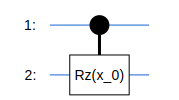

In [9]:
from cirq.contrib.svg import SVGCircuit

# Default Convolution
bits = (1, 2)
symbols = sympy.symbols("x_0:2")
circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
print("Convolution unitary:")
SVGCircuit(circuit)

Pooling unitary:


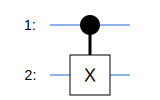

In [10]:
bits = (1, 2)
circuit = cirq.Circuit()
q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
circuit += cirq.CNOT(q0, q1)
print("Pooling unitary:")
SVGCircuit(circuit)

In [263]:
from dynamic_qcnn import Qcnn_cirq as Qcnn_cirq
from dynamic_qcnn import (
    Qcnn,
    Qfree,
    Qconv,
    Qpool,
    Qdense,
    binary_tree_r,
    convert_graph_to_circuit_cirq,
    plot_graph,
    pretty_cirq_plot,
)

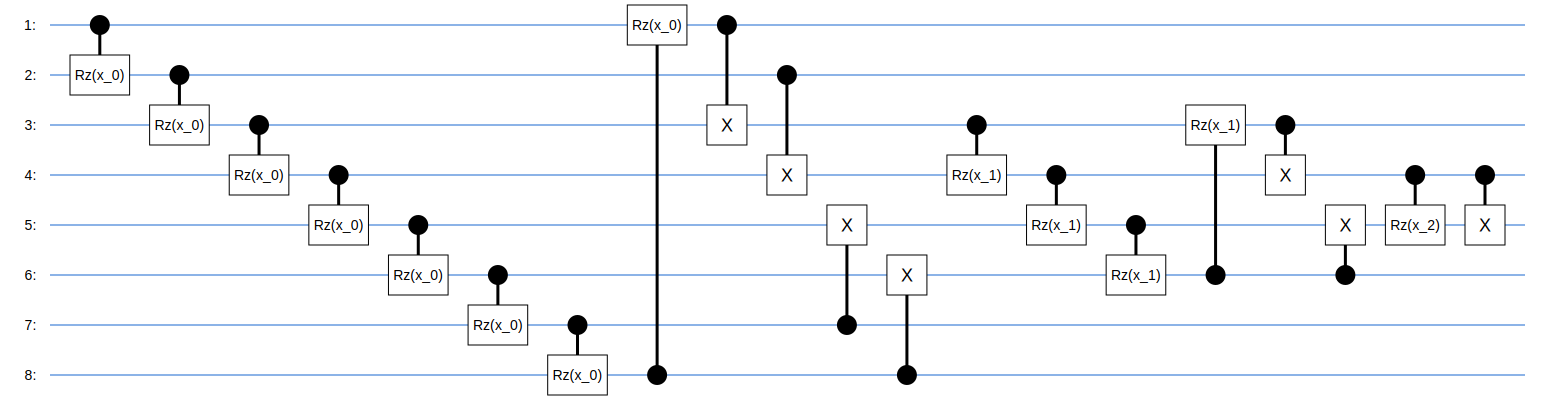

In [270]:
### Reverse binary tree
N = 8
# level 1
m1_1 = Qconv(1)
m1_2 = Qpool(filter="outside")
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

circuit, symbols = convert_graph_to_circuit_cirq(m3_1)
# m3_1 + Qfree([1,3,5]) + Qconv(5)+m3_1)*4
SVGCircuit(circuit)

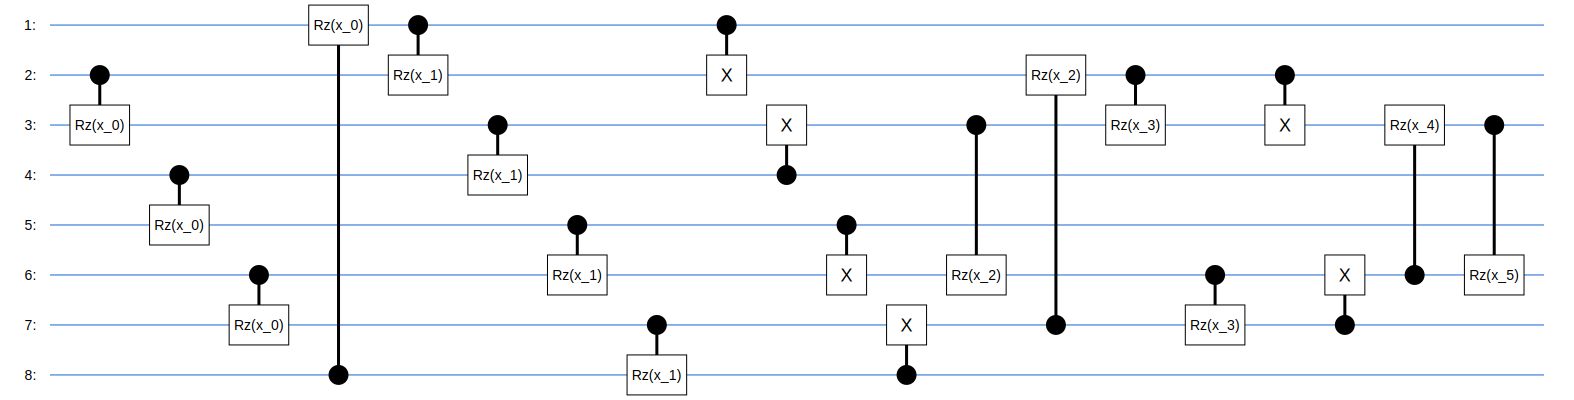

In [13]:
### MERA like
N = 8
# level 1
m1_1 = Qconv(1, 2)
m1_2 = Qconv(1, 2, 1)
m1_3 = Qpool(filter="1001")
m1_4 = Qpool(2, filter="001001")
m1_5 = Qpool(filter="outside")
# level 2
m2_1 = m1_2 + m1_1
m2_2 = m1_3 + m1_4
m2_3 = m1_5
# level 3
m3_1 = Qfree(N) + (m2_1 + m2_2) * 2 + m2_1

circuit, symbols = convert_graph_to_circuit_cirq(m3_1)
SVGCircuit(circuit)

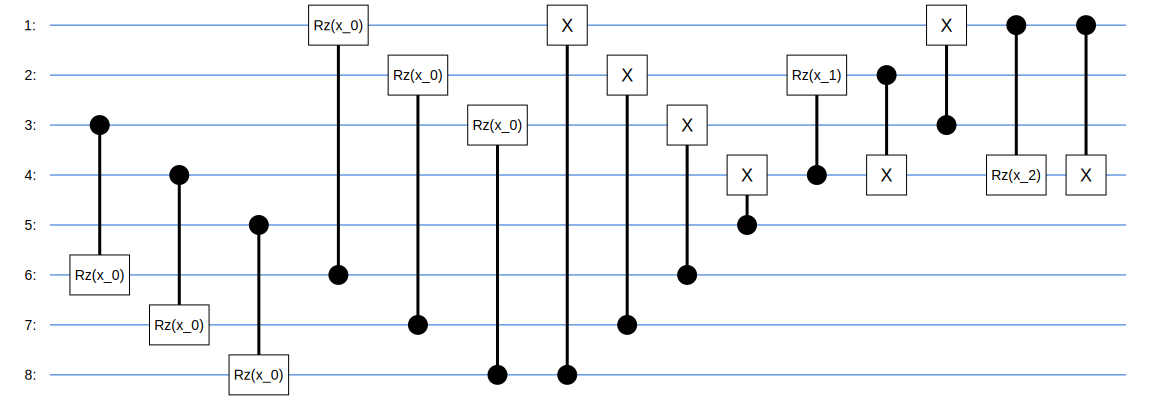

In [239]:
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [Qpool(s_p, filter=i_filter) for i_filter in ("right", "left", "even", "odd", "inside", "outside") for s_p in range(n)]
    c = [Qconv(stride=s_c, step=s_t, offset=s_o) for s_c in range(1, n, 1) for s_t in range(1, 2, 1) for s_o in range(n)]+ [Qdense()]
    M = M + random.choice(c) + random.choice(p)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_cirq(M)
SVGCircuit(circuit)

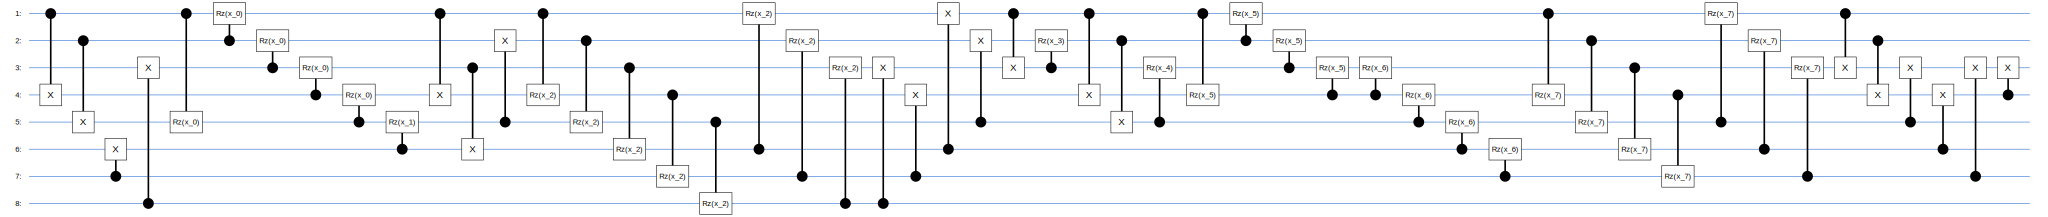

In [265]:
import random
import operator
from functools import reduce
from dynamic_qcnn import Qmotifs

N = 8
M = Qcnn(N)
n = len(M.tail.Q_avail)
while n > 1:
    p = [Qpool(s_p, filter=i_filter) for i_filter in ("right", "left", "even", "odd", "inside", "outside") for s_p in range(n)]
    opt = [Qconv(stride=s_c, step=s_t, offset=s_o) for s_c in range(1, n, 1) for s_t in range(1, 2, 1) for s_o in range(n)]+ [Qdense()]+p+[Qfree(x) for x in range(2,N+1,1)]*5
    M = M + random.choice(opt)
    n = len(M.head.Q_avail)

circuit, symbols = convert_graph_to_circuit_cirq(M)
SVGCircuit(circuit)

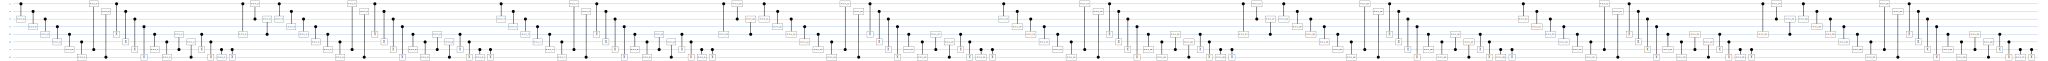

In [266]:
N = 8
# level 1
m1_1 = Qconv(2)
m1_2 = Qpool(filter="left")
# level 2
m2_1 = m1_1 + m1_2
# level 3
m3_1 = Qfree(N) + m2_1 * int(np.log2(N))

circuit, symbols = convert_graph_to_circuit_cirq(
    (m3_1 + Qfree([1, 3, 5]) + Qconv(5) + m3_1) * 4
)
SVGCircuit(circuit)

In [271]:
# from sympy import *
# from sympy.physics.quantum.circuitplot import CircuitPlot,labeller,Mz,CreateOneQubitGate
# from sympy.physics.quantum.gate import *
# from sympy.physics.quantum.qasm import Qasm

# CircuitPlot(CNOT(1,0),2)
# from sympy.physics.quantum.qasm import Qasm
# q = Qasm('qubit q0', 'qubit q1', 'h q0', 'cnot q0,q1')
# q.get_circuit()
# #CNOT(1,0)*H(1)

cirq.qasm(circuit)

ValueError: Cannot output operation as QASM: cirq.Rz(rads=sympy.Symbol('x_0')).on(cirq.LineQubit(2)).controlled_by(cirq.LineQubit(1))

In [11]:
import cirq

# Default pooling circuit
def V(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
    circuit += cirq.X(q0)
    circuit += cirq.rx(symbols[1]).on(q1).controlled_by(q0)
    return circuit


# Default convolution circuit
def U(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.H(q0)
    circuit += cirq.H(q1)
    circuit += cirq.CZ(q0, q1)
    circuit += cirq.rx(symbols[0]).on(q0)
    circuit += cirq.rx(symbols[1]).on(q1)
    return circuit

debug


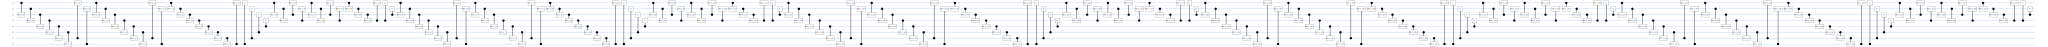

In [13]:
from dynamic_qcnn import Qcnn_cirq as Qcnn_cirq
from dynamic_qcnn import (
    Qcnn,
    Qfree,
    Qconv,
    Qpool,
    Qdense,
    binary_tree_r,
    convert_graph_to_circuit_cirq,
    plot_graph,
    pretty_cirq_plot,
)

# qcnn = Qcnn(8)
# QFree(8)+QConv()
# qcnn = QFree(8)
m1 = Qconv(1) + Qpool()
m2 = Qconv(2) + Qconv(2)
m3 = m2 + m1 + m2 + m1
m4 = Qfree(8) + m3
m5 = m4 * 5
# m3 = m2*6 + QFree(16) +QConv()
# QFree(8)+QFree(16)
circuit, symbols = convert_graph_to_circuit_cirq(m5)
SVGCircuit(circuit)

Build a simple 4 qubit QCNN

In [13]:
from dynamic_qcnn import Qcnn_cirq as Qcnn
from dynamic_qcnn import (
    Qcnn,
    QFree,
    QConv,
    QPool,
    binary_tree_r,
    convert_graph_to_circuit_cirq,
    plot_graph,
    pretty_cirq_plot,
)

nq = 2
qcnn = Qcnn(QFree(nq))
motif_1 = QConv(1, convolution_mapping=(U, 2)) + QPool(
    pool_filter="right", pooling_mapping=(V, 2)
)
# motif_2 = QConv(2) + QPool(pool_filter="left")
# motif_3 = qcnn+motif_1+motif_2+motif_1
# motif_4 = qcnn+motif_1+motif_1+motif_1
# motif_2 = qcnn + motif_1*3
# motif_3 = motif_2 + QFree(8) + QPool(pool_filter="10101000")+QConv(2)
# motif_4 = motif_3+motif_3+ QFree(8) + (QConv() + QPool(pool_filter="right"))*3
# motif_5 = motif_4 +motif_4 + motif_4
# motif_6 = motif_3+motif_4+QFree(16)+motif_1*4+QFree(2)+QConv()+QPool(pool_filter="10")+QFree([14,11])+QConv()
# circuit, symbols = convert_graph_to_circuit_cirq(qcnn+motif_1, pretty=True)
# SVGCircuit(circuit)

TypeError: __init__() got an unexpected keyword argument 'pool_filter'

In [260]:
from dynamic_qcnn import Qcnn_cirq as Qcnn
from dynamic_qcnn import (
    QConv,
    QPool,
    binary_tree_r,
    convert_graph_to_circuit_cirq,
    plot_graph,
)

head_graph, _ = binary_tree_r(4)
circuit, symbols = convert_graph_to_circuit_cirq(head_graph)
SVGCircuit(circuit)

ImportError: cannot import name 'QConv' from 'dynamic_qcnn' (/home/matt/dev/projects/quantum_estimators/dynamic_qcnn/__init__.py)

Scale up the same model, and alternate architectures

In [ ]:
# head_graph, _ = binary_tree_r(8, s_c=1, s_p=0, pool_filter="right")
# head_graph, _ = binary_tree_r(8, s_c=1, s_p=0, pool_filter="left")
# head_graph, _ = binary_tree_r(8, s_c=3, s_p=2, pool_filter="left")
# head_graph, _ = binary_tree_r(8, s_c=1, s_p=0, pool_filter="inside")
head_graph, _ = binary_tree_r(8, s_c=1, s_p=0, pool_filter="outside")
circuit, symbols = convert_graph_to_circuit_cirq(head_graph)
SVGCircuit(circuit)

In [29]:
# base = QConv(8)
base = QConv(8, stride=3)
SVGCircuit(convert_graph_to_circuit_cirq(base)[0])

NameError: name 'QConv' is not defined

In [22]:
base = QConv(8)
a = QPool(base)
b = a(a)
# QPool(QConv(QPool(QConv(base, stride=3), pool_filter="right")),pool_filter="0001", stride=2)
# QPool(QConv(QPool(QConv(base, stride=3), pool_filter="right")), pool_filter="0001", stride=1)
SVGCircuit(convert_graph_to_circuit_cirq(b)[0])

ValueError: Can't draw SVG diagram for empty circuits

In [19]:
base()

TypeError: 'QConv' object is not callable

In [4]:
import cirq

# Default pooling circuit
def V(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rz(symbols[0]).on(q1).controlled_by(q0)
    circuit += cirq.X(q0)
    circuit += cirq.rx(symbols[1]).on(q1).controlled_by(q0)
    return circuit


# Default convolution circuit
def U(bits, symbols=None):
    circuit = cirq.Circuit()
    q0, q1 = cirq.LineQubit(bits[0]), cirq.LineQubit(bits[1])
    circuit += cirq.rx(symbols[0]).on(q0)
    circuit += cirq.rx(symbols[1]).on(q1)
    circuit += cirq.rz(symbols[2]).on(q0)
    circuit += cirq.rz(symbols[3]).on(q1)
    circuit += cirq.rz(symbols[4]).on(q1).controlled_by(q0)
    circuit += cirq.rz(symbols[5]).on(q0).controlled_by(q1)
    circuit += cirq.rx(symbols[6]).on(q0)
    circuit += cirq.rx(symbols[7]).on(q1)
    circuit += cirq.rz(symbols[8]).on(q0)
    circuit += cirq.rz(symbols[9]).on(q1)
    return circuit

In [ ]:
# head_graph, _ = binary_tree_r(8, convolution_mapping={1:(U,10)}, pooling_mapping={1:(V,2)})
head_graph, _ = binary_tree_r(
    8,
    pool_filter="left",
    s_c=5,
    convolution_mapping={1: (U, 10)},
    pooling_mapping={1: (V, 2)},
)
circuit, symbols = convert_graph_to_circuit_cirq(head_graph)
SVGCircuit(circuit)

In [ ]:
base = QConv(8, stride=1)
plot_graph(base)
plot_graph(QPool(base, pool_filter="10000100"))
plot_graph(QConv(QPool(base, pool_filter="10000100"), stride=2))
plot_graph(QPool(QConv(QPool(base, pool_filter="10000100")), pool_filter="odd"))
plot_graph(QConv(QPool(QConv(QPool(base, pool_filter="10000100")), pool_filter="even")))

In [ ]:
# === Specify hyperparamaters ===
# Number of qubits (since we're using qubit encoding ensure there is a one-one mapping between feature and qubit)
n_q = 8
# Convolution Stride
s_c = 5
# Pooling Stride
s_p = 0
# Pooling Filter, options: right, left, inside, outside, even, odd
pool_filter = "right"

head_graph, tail_graph = binary_tree_r(
    n_q=n_q,
    s_c=s_c,
    s_p=s_p,
    pool_filter=pool_filter,
    convolution_mapping={1: (U, 10)},
    pooling_mapping={1: (V, 2)},
)
readout = cirq.LineQubit(tail_graph.E[0][1])
circuit, symbols = convert_graph_to_circuit_cirq(head_graph)

model = tf.keras.Sequential(
    [
        # The Qcnn layer returns the expected value of the readout gate, range [-1,1]. By default readout is criq.Z and the model determines
        # which qubit to measure based on the one that's left over
        Qcnn(circuit=circuit, symbols=symbols, readout=readout),
        # Convert expectation values to lie between 0 and 1
        tf.keras.layers.Rescaling(1.0 / 2, offset=0.5),
    ]
)

In [ ]:
model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
)
# model.run_eagerly = True
model.fit(x=samples_encoded.X_train, y=samples_encoded.y_train, epochs=100)

### Evaluate

In [ ]:
model.summary()
print(model.trainable_variables)

qcnn_results = model.evaluate(samples_encoded.X_test, samples_encoded.y_test)
# results.append([f"{s_c}_{s_p}_{pool_filter}", qcnn_results])
print(qcnn_results)

In [ ]:
SVGCircuit(circuit)